In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import gc
import PIL
import pytz
import time
import shutil
import random
import splitfolders
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from collections import Counter
from datetime import datetime,timezone
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,classification_report
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

In [10]:
input_dir = "./drive/MyDrive/Rock_Classification/Data"
output_dir =  "./drive/MyDrive/Rock_Classification/Dataset"
splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8,.1,.1), group_prefix=None)



Copying files: 0 files [00:00, ? files/s]

Copying files: 1 files [00:00,  7.66 files/s]

Copying files: 6 files [00:00,  9.65 files/s]

Copying files: 15 files [00:00, 25.10 files/s]

Copying files: 22 files [00:00, 34.12 files/s]

Copying files: 31 files [00:00, 46.62 files/s]

Copying files: 39 files [00:01, 53.72 files/s]

Copying files: 46 files [00:01, 54.59 files/s]

Copying files: 53 files [00:01, 55.93 files/s]

Copying files: 61 files [00:01, 61.64 files/s]

Copying files: 69 files [00:01, 66.53 files/s]

Copying files: 77 files [00:01, 69.98 files/s]

Copying files: 87 files [00:01, 73.87 files/s]

Copying files: 97 files [00:01, 80.46 files/s]

Copying files: 106 files [00:01, 77.20 files/s]

Copying files: 114 files [00:02, 76.73 files/s]

Copying files: 122 files [00:02, 74.40 files/s]

Copying files: 131 files [00:02, 78.57 files/s]

Copying files: 139 files [00:02, 75.09 files/s]

Copying files: 148 files [00:02, 77.16 files/s]

Copying files: 156 files [00:02, 73.97 

In [11]:
DATADIR = output_dir
TRAIN_DATADIR = os.path.join(DATADIR, 'train')
TEST_DATADIR = os.path.join(DATADIR, 'test')
VAL_DATADIR = os.path.join(DATADIR, 'val')

In [12]:
CATEGORIES = []
for c in os.listdir(TRAIN_DATADIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['Quartzite', 'Highland', 'Coal', 'Granite', 'Sandstone', 'Basalt', 'Marble', 'Limestone']


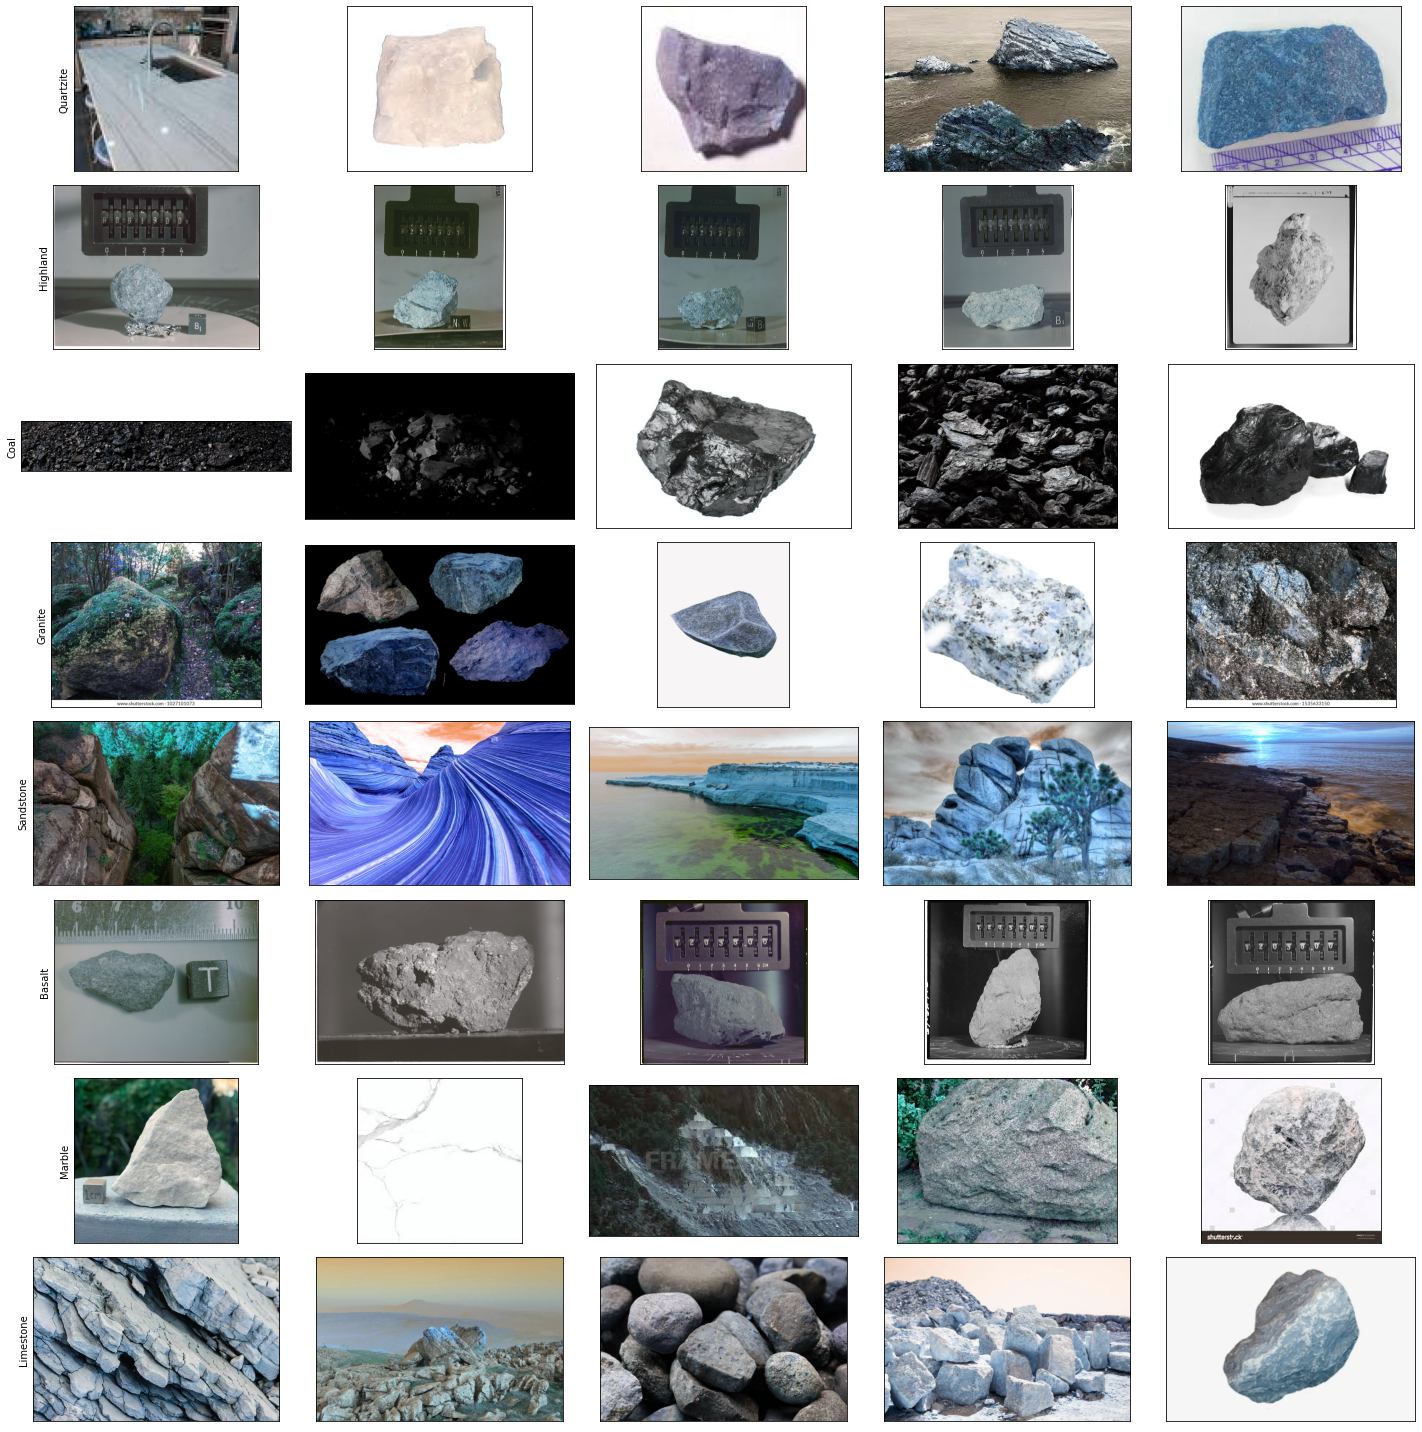

In [15]:
plt.figure(figsize=(20,20))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATADIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(len(CATEGORIES),5,i+1)
        plt.imshow(img_array)
        if i%5 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%5 == 0:
            break
plt.tight_layout()        
plt.show()

In [16]:
IMG_SHAPE = (224,224,3)


In [17]:
def min_max_scalar(img, scale_range =(0, 1)):
    
    px_min = scale_range[0]
    px_max = scale_range[1]
    img = img.astype('float32')
    img = img/img.max()
    scaled_img = img * (px_max - px_min) + px_min
    return scaled_img

def resize(img,size):
    resized_img = img.resize(size, Image.ANTIALIAS)
    resized_img_array = np.asarray(resized_img)
    return resized_img_array

def del_corrupted_images(filepaths):
    del_count = 0
    for filepath in filepaths:
        try:
            fobj = open(filepath,'rb')
            is_JFIF =  b'JFIF' in fobj.peek(10)
        finally:
            fobj.close()
        if not is_JFIF:
            del_count += 1
            os.remove(filepath)
    print(f"Total {del_count} corrupted image deleted")
    return None

def find_filepaths(root_folder):
    filepaths = []
    for dirname, _, filenames in os.walk(root_folder):
        for filename in filenames:
            filepaths.append(os.path.join(dirname, filename))
    return filepaths

In [18]:
filepaths = find_filepaths(DATADIR)
del_corrupted_images(filepaths)

Total 129 corrupted image deleted


In [19]:
def load_and_prepare_dataset(dataset_dir,IMG_SHAPE):
    
    rock_classes = os.listdir(dataset_dir)
    
    filepaths = find_filepaths(dataset_dir)
    no_of_total_images = len(filepaths)
    
    data = np.zeros((no_of_total_images,*IMG_SHAPE),dtype='float32')
    label = []
    ix = 0
    
    for class_label in rock_classes:
        class_path = os.path.join(dataset_dir, class_label)
        for img in os.listdir(class_path):
            image = Image.open(os.path.join(class_path, img))
            resized_image = resize(image,IMG_SHAPE[:-1])
            image_array = min_max_scalar(resized_image)
            if image_array.shape == IMG_SHAPE:
                data[ix]=image_array
                label.append(class_label)
            else:
                image_array=np.stack((image_array,)*3, axis=-1)
                data[ix]=image_array
                label.append(class_label)
            ix += 1
    label = np.asarray(label)
    label = label.reshape((-1,1))
        
    return data,label

In [20]:
X_train,y_train = load_and_prepare_dataset(TRAIN_DATADIR,IMG_SHAPE)
X_val,y_val = load_and_prepare_dataset(VAL_DATADIR,IMG_SHAPE)
X_test,y_test = load_and_prepare_dataset(TEST_DATADIR,IMG_SHAPE)

In [21]:
print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of X_val = {X_val.shape}")
print(f"Shape of y_val = {y_val.shape}")
print(f"Shape of X_test = {X_test.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of X_train = (1615, 224, 224, 3)
Shape of y_train = (1615, 1)
Shape of X_val = (197, 224, 224, 3)
Shape of y_val = (197, 1)
Shape of X_test = (211, 224, 224, 3)
Shape of y_test = (211, 1)


In [22]:
def show_unique_images(X,y,idx=0):
    y = np.squeeze(y)
    unique = np.unique(y)
    index=[]
    for i in unique:
        try:
            r = np.where(y==i)
            index.append (r[0][idx])
        except:
            pass
    
    images=[]
    labels=[]
    for i in index:
        images.append(X[i])
        labels.append(y[i])
    
    plt.figure(figsize=(16,9))
    
    for i in range(np.unique(y).size):
        ax = plt.subplot(1,8, i+1)
        
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis("off")
        
    return None

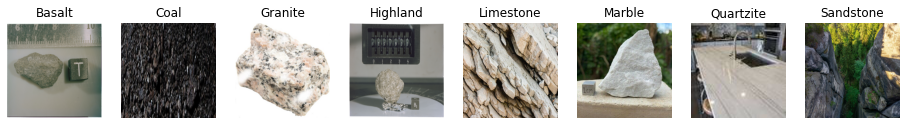

In [23]:
show_unique_images(X_train,y_train)

In [24]:
classes = Counter(np.squeeze(y_train).tolist()).keys()
values = Counter(np.squeeze(y_train).tolist()).values()
rock_count_per_class_before_smote = dict(zip(classes,values))
print(rock_count_per_class_before_smote)

{'Quartzite': 377, 'Highland': 51, 'Coal': 284, 'Granite': 52, 'Sandstone': 256, 'Basalt': 72, 'Marble': 307, 'Limestone': 216}


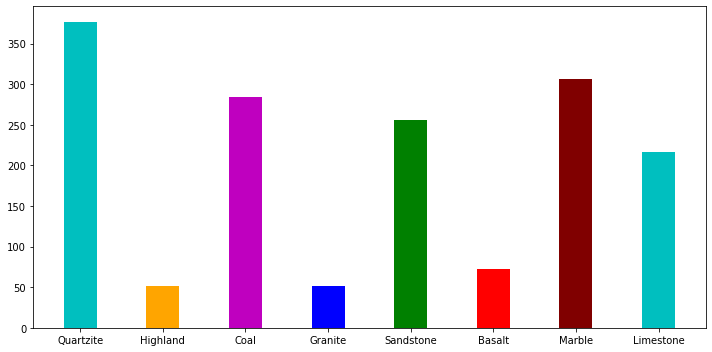

In [25]:
fig = plt.figure(figsize = (10, 5))
 
rock_names = list(rock_count_per_class_before_smote.keys())
rock_counts = list(rock_count_per_class_before_smote.values())
plt.bar(rock_names,rock_counts,color =['c','orange','m','b','g','r','maroon'],width = 0.4)
plt.tight_layout()  

In [26]:
# Reshaping is important for feeding the data into fit_resample method of SMOTE class
X_train = X_train.reshape((-1,IMG_SHAPE[0]*IMG_SHAPE[1]*IMG_SHAPE[2]))
print(f"Shape of data is {X_train.shape}")
print(f"Shape of label is {y_train.shape}")
print(f"Data type of data is {type(X_train)}")
print(f"Data type of label is {type(y_train)}")

Shape of data is (1615, 150528)
Shape of label is (1615, 1)
Data type of data is <class 'numpy.ndarray'>
Data type of label is <class 'numpy.ndarray'>


In [27]:
smote = SMOTE(random_state=42)
X_train = X_train.reshape((-1,IMG_SHAPE[0]*IMG_SHAPE[1]*IMG_SHAPE[2]))
X_train, y_train = smote.fit_resample(X_train,y_train)

In [28]:
X_train = X_train.reshape((-1,*IMG_SHAPE))
y_train = y_train.reshape((-1,1))
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of y_train : {y_train.shape}")

Shape of X_train : (3016, 224, 224, 3)
Shape of y_train : (3016, 1)


In [29]:
classes = Counter(np.squeeze(y_train).tolist()).keys()
values =Counter(np.squeeze(y_train).tolist()).values()
rock_count_per_class_after_smote = dict(zip(classes,values))
print(rock_count_per_class_after_smote)

{'Quartzite': 377, 'Highland': 377, 'Coal': 377, 'Granite': 377, 'Sandstone': 377, 'Basalt': 377, 'Marble': 377, 'Limestone': 377}


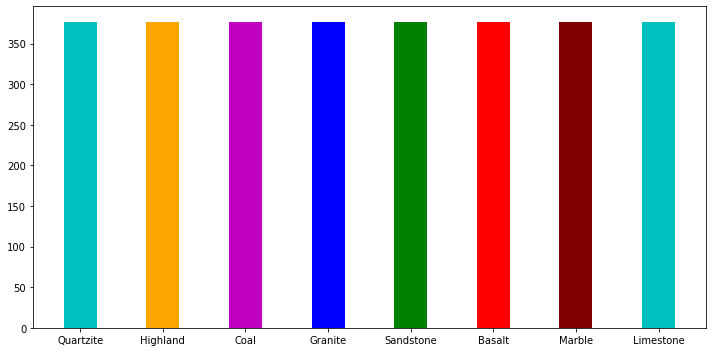

In [30]:
fig = plt.figure(figsize = (10, 5))
 
rock_names = list(rock_count_per_class_after_smote.keys())
rock_counts = list(rock_count_per_class_after_smote.values())
plt.bar(rock_names,rock_counts,color =['c','orange','m','b','g','r','maroon'],width = 0.4)
plt.tight_layout()  

In [31]:
def one_hot_encoder(array):
    encoded_array = []
    unique = np.unique(array)
    for item in array:
        encoded_item = item == unique
        encoded_array.append(encoded_item)
    encoded_array = np.asarray(encoded_array)
    encoded_array = encoded_array.astype(int)
    return encoded_array

In [32]:
y_train_encoded = one_hot_encoder(y_train)
y_val_encoded = one_hot_encoder(y_val)
y_test_encoded = one_hot_encoder(y_test)

In [33]:
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of y_train_encoded = {y_train_encoded.shape}")
print(f"Shape of y_val = {y_val.shape}")
print(f"Shape of y_val_encoded = {y_val_encoded.shape}")
print(f"Shape of y_test = {y_test.shape}")
print(f"Shape of y_test_encoded = {y_test_encoded.shape}")

Shape of y_train = (3016, 1)
Shape of y_train_encoded = (3016, 8)
Shape of y_val = (197, 1)
Shape of y_val_encoded = (197, 8)
Shape of y_test = (211, 1)
Shape of y_test_encoded = (211, 8)


In [34]:
class PrettyPrint(tf.keras.callbacks.Callback):
    
    def __init__(self,batches):
        super(PrettyPrint,self).__init__()
        self.batches = batches
        self.lr = None

    
    def print_in_color(self,txt_msg,fore_tupple,back_tupple,):
        #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
        #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
        rf,gf,bf=fore_tupple
        rb,gb,bb=back_tupple
        msg='{0}' + txt_msg
        mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
        print(msg .format(mat), flush=True)
        print('\33[0m', flush=True) # returns default print color to back to black
        return None

    def on_train_begin(self, logs=None):
        msg=f"{'Epoch':^10s}{'Train_Loss':^12s}{'Train_Acc':^12s}{'Val_Loss':^12s}{'Val_Acc':^12s}{'LR':^12s}{'Duration':^10s}"
        self.print_in_color(msg, (0, 255, 76), (55,65,80))
        self.lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))

        
    def on_train_end(self, logs=None):
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        self.print_in_color(msg,  (255,100,255), (55,65,80))
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
    def on_epoch_begin(self,epoch, logs=None):
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        end_time =time.time()
        duration = end_time-self.start_time
        
        lr = self.lr
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        if self.lr != current_lr:
            self.lr = current_lr 
            
        train_acc = logs.get('accuracy')*100
        train_loss = logs.get('loss')
        val_acc = logs.get('val_accuracy')*100
        val_loss =logs.get('val_loss')
        
        msg = f"{str(epoch+1):^10s}{train_loss:^12.3f}{train_acc:^12.3f}{val_loss:^12.5f}{val_acc:^12.5f}{lr:^12.9f}{duration:^10.3f}"
        self.print_in_color (msg,(0,255,255), (55,65,80))

In [35]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l1_l2

In [36]:
BaseModel = MobileNet(weights='imagenet', include_top=False, input_shape= IMG_SHAPE )

Copying files: 958 files [14:50,  1.08 files/s]
Copying files: 1203 files [08:26,  2.38 files/s]


17235968/17225924 [==============================] - 0s 0us/step


In [37]:
output_size = len(y_train_encoded[0])
print(f"Output Size = {output_size}")

Output Size = 8


In [38]:
model = Sequential()

model.add(BaseModel)

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu',
                kernel_regularizer=l1_l2(0.01),
                bias_regularizer=l1_l2(0.01)))

model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(output_size, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization (BatchN  (None, 50176)            200704    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                        

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(learning_rate=0.001),
              metrics=['accuracy']) 

In [45]:
batch_size = 32
train_steps=int(len(y_train)/batch_size)
batches=train_steps

In [46]:
color_print = PrettyPrint(batches)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,
                                                 patience=1,verbose=0)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=0,
                                              restore_best_weights=True)

callbacks = [color_print,reduce_lr,early_stop]

In [47]:
print(X_train.shape[0]==y_train_encoded.shape[0])
print(type(X_train) == type(y_train_encoded))
print(X_train.shape)
print(y_train_encoded.shape)
print(X_val.shape)
print(y_val_encoded.shape)

True
True
(3016, 224, 224, 3)
(3016, 8)
(197, 224, 224, 3)
(197, 8)


In [48]:
history = model.fit(X_train,y_train_encoded, 
                    validation_data=(X_val,y_val_encoded),
                    batch_size=batch_size, epochs=30,verbose=0,
                    callbacks=callbacks)

  Epoch    Train_Loss  Train_Acc    Val_Loss    Val_Acc        LR      Duration 

    1        45.590      76.724     27.57280    56.34518  0.001000000   33.263  

    2        21.237      85.146     20.98467    65.98985  0.001000000   30.710  

    3        18.410      86.969     18.69349    62.43655  0.001000000   30.689  

    4        15.138      90.550     15.05351    68.52792  0.001000000   31.084  

    5        14.309      92.275     16.36917    73.09645  0.001000000   30.616  

    6        9.788       94.728     10.20987    68.52792  0.001000000   30.604  

    7        8.236       95.723     8.97121     74.11168  0.000500000   30.762  

    8        7.775       96.684     8.83111     75.12690  0.000500000   30.721  

    9        7.063       96.684     6.80857     76.14213  0.000500000   30.631  

    10       6.631       96.983     8.50772     78.68021  0.000500000   30.790  

    11       4.812       97.944     6.24023     76.64974  0.000500000   30.659  

    12       4.4

In [49]:
def plot_accuracy_loss(history):
    f,ax = plt.subplots(1,2,figsize=(12,6))
    
    ax[0].plot([None]+history.history['accuracy'],'o-')
    ax[0].plot([None]+history.history['val_accuracy'],'o-')
    ax[0].legend(['Train Accuracy','Validation Accuracy'],loc = 0)
    ax[0].set_title('Training & Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot([None]+history.history['loss'],'o-')
    ax[1].plot([None]+history.history['val_loss'],'o-')
    ax[1].legend(['Training Loss','Validation Loss'],loc = 0)
    ax[1].set_title('Training & Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    
    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()
    
    return None

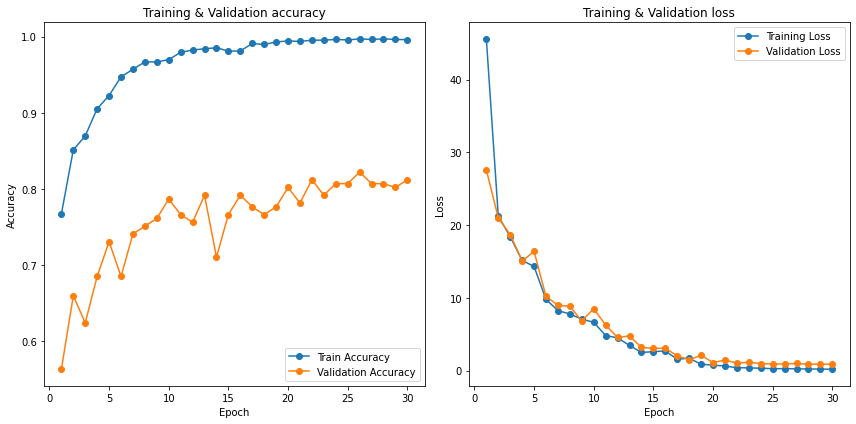

In [50]:
plot_accuracy_loss(history)

In [51]:
result = model.evaluate(X_test,y_test_encoded)
print(result)

7/7 [==============================] - 1s 163ms/step - loss: 0.6579 - accuracy: 0.8436
[0.6579232811927795, 0.8436018824577332]


In [52]:
predictions =np.argmax(model.predict(X_test), axis=-1)
print(predictions)

[6 6 6 6 5 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 5 6 6 6 5 5 6 3 3 3 3 3 3 3 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 6 1 1 1 1 1 1 1 6 1 1 1 2 4 5 7 2 2 6 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 4 6 6 5 5
 6 5 5 5 7 5 7 6 5 5 7 5 5 5 5 5 5 5 7 5 5 5 5 6 5 1 6 6 6 5 5 5 5 5 7 4 4
 4 4 4 4 5 4 4 4 4 4 6 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4]


In [53]:
def label_encoder(string):
    rock_classes = ['Basalt','Highland','Coal', 'Granite','Limestone','Marble','Quartzite', 'Sandstone']
    for i,rock in enumerate(rock_classes):
        if string == rock:
            return i
y_test_enc = np.asarray(list(map(label_encoder,np.squeeze(y_test).tolist())))
print(y_test_enc)

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [54]:
print(classification_report(y_test_enc,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00         7
           4       0.86      0.89      0.88        28
           5       0.71      0.62      0.67        40
           6       0.78      0.86      0.82        49
           7       0.84      0.97      0.90        33

    accuracy                           0.64       211
   macro avg       0.52      0.54      0.53       211
weighted avg       0.61      0.64      0.62       211



In [55]:
def display_confusion_matrix(confusion_matrix,labels):
    conf_matrix_df = pd.DataFrame(confusion_matrix,
                         index = labels,
                         columns = labels)
    plt.figure(figsize=(15,6))
    sns.heatmap(conf_matrix_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    return None

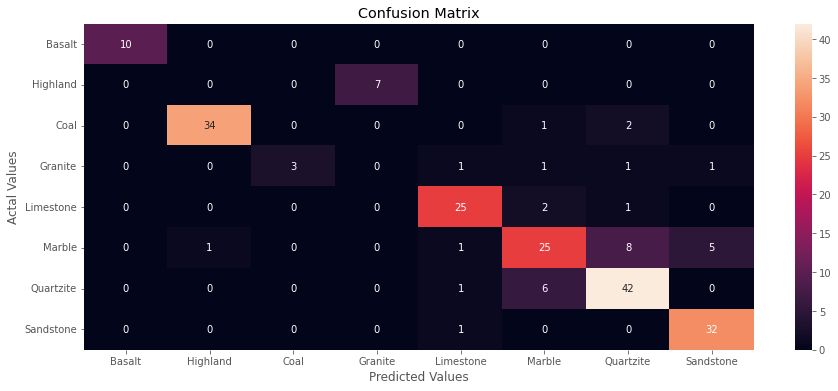

In [56]:
labels =  ['Basalt','Highland','Coal', 'Granite','Limestone','Marble','Quartzite', 'Sandstone']
conf_matrix = confusion_matrix(y_test_enc,predictions)
display_confusion_matrix(conf_matrix,labels)

In [57]:
 model.save("./drive/MyDrive/Rock_Classification/rock_classification.h5")